In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file
import config

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み


In [2]:
df_cross = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR
    + "/df_cross_{0}.pkl".format(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY])
)
df_cross.head()

,PATIENT_ID,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CD164,MOB3A,KIF25-AS1,OR1J2,GNG5,...,INPP5F,ZNF683,MFAP1,TMEM168,STUB1,ELANE,SHISA2,BCAT1,NCKAP1L,CATSPERD,PSMC3IP,TEAD1,GRHPR,EGLN2,TBC1D4,ANGPTL2,ENOX1,SBF2-AS1,VN1R4,UGGT1,VPS72,CSMD3,CC2D1A,IGSF9,FAM71A
0,MB-0000,False,False,NaN,claudin-low,-0.0120,-1.1056,4.5196,0.0329,0.3862,-2.0219,-0.2429,2.1378,0.5495,1.8284,-0.8398,-0.1142,-1.7540,-1.2755,0.0196,-0.0522,-1.2824,0.5897,-0.3029,-0.5228,...,0.9475,-0.9120,-0.3074,0.1521,-0.5106,1.3997,-0.9917,-0.1982,0.0272,0.4792,-0.6417,0.5771,0.0594,-1.2168,0.8393,1.5746,1.4772,-1.2587,0.3048,-1.2102,0.1724,-0.0968,-0.4385,-1.2266,-0.7888
1,MB-0002,False,NaN,NaN,LumA,-0.9754,-1.2345,-0.2178,0.0345,1.3780,-1.3438,-0.1896,0.1974,1.5447,2.2324,-0.5702,1.2907,0.5034,-0.3811,-1.0740,0.4406,0.6710,0.6737,-0.5655,0.4570,...,-1.1211,-0.9657,-1.1362,0.8143,0.5264,0.3201,0.9288,-0.5112,-1.7165,-3.2289,0.9063,2.4823,0.4596,-1.2913,-1.1835,0.6860,-0.2834,-0.1178,-0.9119,-0.0436,0.0931,-0.5014,-0.0856,0.5231,1.3184
2,MB-0005,False,False,True,LumB,-1.2369,-0.6683,0.0388,1.3961,-0.1890,1.5054,-0.1051,1.9259,-1.4087,0.8772,0.0634,0.5388,-1.8249,-1.8733,-2.0042,4.5635,-1.3689,-0.4228,0.5096,-0.6763,...,-0.2585,-1.3112,-0.1760,1.3253,-0.9020,-1.9443,0.7425,1.6060,-0.6394,0.1655,-0.1446,1.3467,-1.2727,-1.6672,0.6575,0.7729,-1.0080,-0.6883,-0.4368,-2.0045,0.2941,-0.0720,-0.1664,1.3332,1.5020
3,MB-0006,False,False,NaN,LumB,-1.4532,-0.6241,-0.9954,0.9550,-0.3821,-0.5567,2.1362,0.8176,-1.1097,-0.5361,-0.9623,-0.6191,-1.0476,-2.5493,-1.6123,5.6814,-1.3153,-0.3836,0.9926,-0.0480,...,-0.2523,0.1199,0.0295,-1.5261,-1.7477,-1.5714,1.3007,2.1700,-1.0093,-0.5112,-1.3530,0.4042,0.5895,-1.4498,0.3101,0.4233,0.3079,-1.2554,1.8796,-1.3191,-1.5679,-0.4885,0.6320,-0.8236,0.2000
4,MB-0008,True,True,True,LumB,-1.2669,-0.2296,2.0700,-0.7105,0.3735,1.3603,0.5765,-0.4034,-1.0353,1.4386,2.1507,-0.3227,-0.1100,-0.3917,-0.9916,-0.5012,-1.4905,-0.2076,-0.1656,-0.5703,...,-0.2081,-0.7431,0.3272,0.2224,0.3766,-0.5099,-1.1252,-0.1921,-0.6421,0.2314,0.7798,2.2265,-0.3720,0.4236,-1.9978,-0.1704,-0.2313,-2.0527,0.3099,-1.3665,0.5494,-0.2719,-0.1021,-0.6526,-1.2493


<AxesSubplot:xlabel='STAT5B', ylabel='Count'>

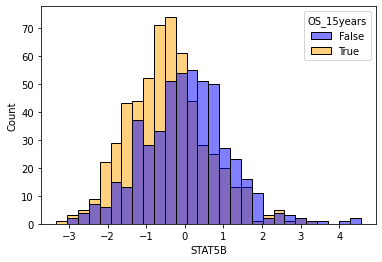

In [3]:
sns.histplot(
    x="STAT5B", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)

<AxesSubplot:xlabel='ENC1', ylabel='Count'>

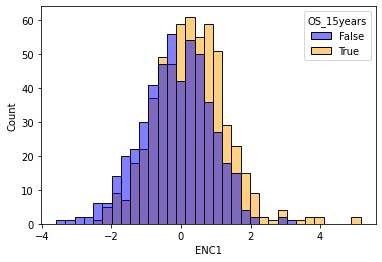

In [4]:
sns.histplot(
    x="ENC1", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)

<AxesSubplot:xlabel='RNU11', ylabel='Count'>

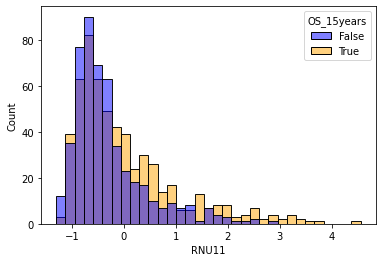

In [5]:
sns.histplot(
    x="RNU11", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)

# Draw KM line

to use OS_MONTHS and OS_STATUS, read raw patient data

In [6]:
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_MB.pkl")
df_merged = pd.merge(
    df_cross,
    df_MB.drop("CLAUDIN_SUBTYPE", axis=1),
    right_on="PATIENT_ID",
    left_on="PATIENT_ID",
)

In [7]:
def plot_KM(target: str, threshold: float = 0, is_save: bool = False):
    ax = None
    df_merged["OS_STATUS_INT"] = df_merged["OS_STATUS"].replace(
        {"0:LIVING": 0, "1:DECEASED": 1}
    )
    df_merged["target_gene"] = df_merged[target].apply(
        lambda x: 1 if x > threshold else 0
    )
    plt.figure()
    kmf = KaplanMeierFitter()
    for name, group in df_merged.groupby("target_gene"):
        kmf.fit(
            group["OS_MONTHS"],
            event_observed=group["OS_STATUS_INT"],
            label="is deceased: {0}".format(name),
        )
        ax = kmf.plot(ax=ax) if ax else kmf.plot()

    make_dir(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR)

    plt.title(target)
    plt.savefig(
        "{0}/{1}.png".format(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR, target)
    ) if is_save else plt.show()

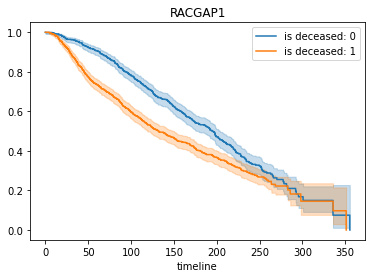

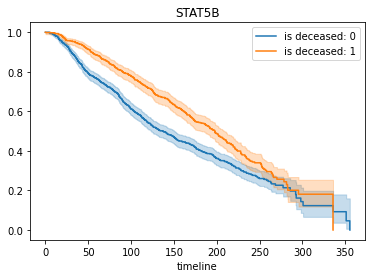

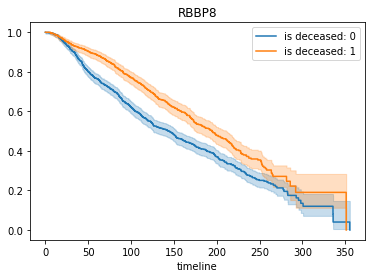

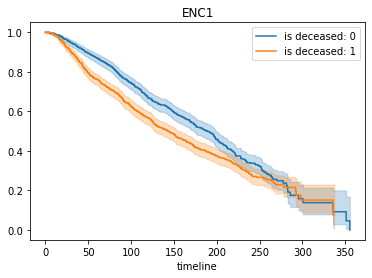

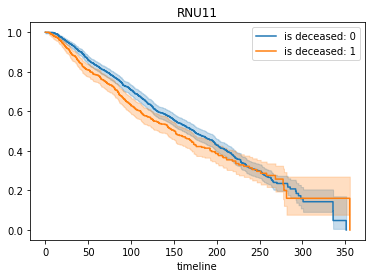

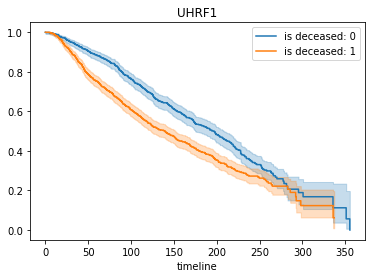

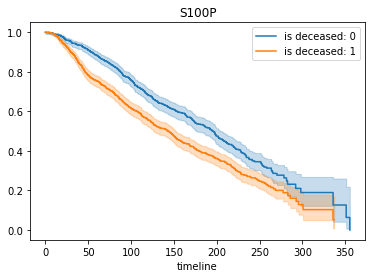

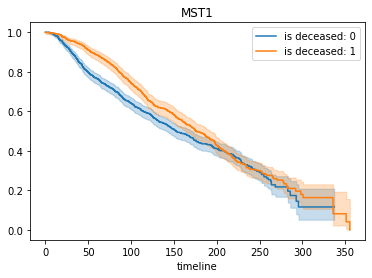

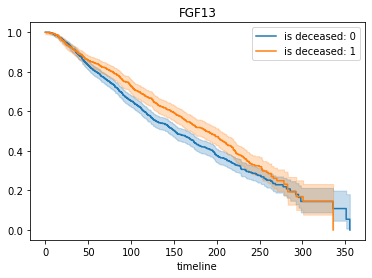

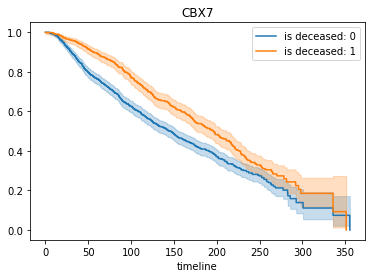

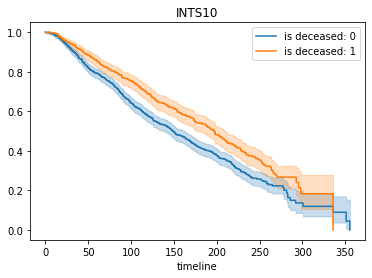

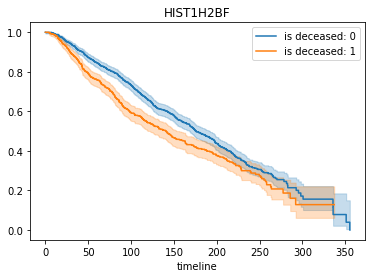

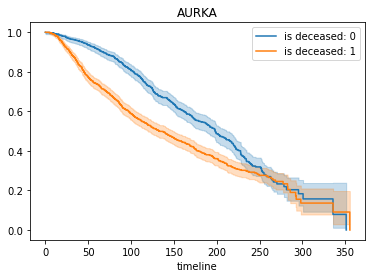

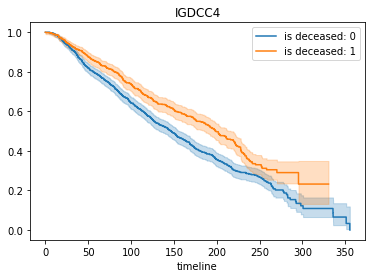

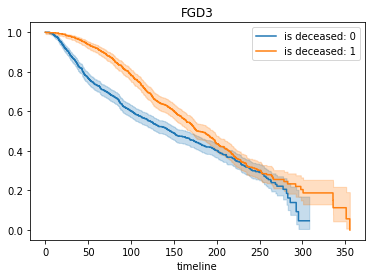

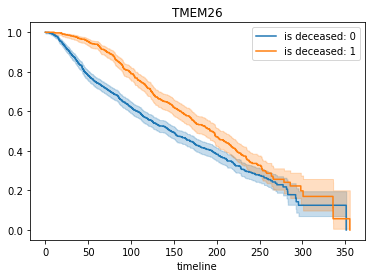

In [8]:
gene_list = [
    "RACGAP1",
    "STAT5B",
    "RBBP8",
    "ENC1",
    "RNU11",
    "UHRF1",
    "S100P",
    "MST1",
    "FGF13",
    "CBX7",
    "INTS10",
    "HIST1H2BF",
    "AURKA",
    "IGDCC4",
    "FGD3",
    "TMEM26",
]

for t in gene_list:
    plot_KM(t, 0, is_save=True)

# Draw Cox proportional hazard model

## dupulicated genes between all microarray

Iteration 1: norm_delta = 0.36500, step_size = 0.9000, log_lik = -6804.90663, newton_decrement = 90.80823, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.05132, step_size = 0.9000, log_lik = -6715.44211, newton_decrement = 1.32572, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00557, step_size = 0.9000, log_lik = -6714.12236, newton_decrement = 0.01617, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, log_lik = -6714.10617, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1743 total observations, 737 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1743
number of events observed = 1006
   partial log-likelihood = -6714.11
         time fit was run = 2022-09-04 13:08:34 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RACGAP1     0.08       1.08       0.06            -0.04             0.19                 0.96                 1.21
STAT5B     -0.06       0.95       0.03            -0.12             0.01                 0.89                 1.01
RBBP8      -0.17       0.85       0.04            -0.24            -0.10                 0.79                 0.91
ENC1        0.18       1.20       0.03             0.11             0.24                 1.12                 1.28
RNU11       0.02       1.02       0.04            -0.06             0.09                 0.94                 1.10
UHRF1       0.05       1.05       0.05            -0.05             0.15                 0.95                 1.16
S100P       0.04       1.04       0.04            -0.03             0.11                 0.97                 1.12
MST1        0.05       1.05       0.04            -0.02             0.12                 0.98                 1.13
FGF13      -0.11       0.90       0.04            -0.18            -0.04                 0.83                 0.96
CBX7       -0.06       0.94       0.04            -0.14             0.02                 0.87                 1.02
INTS10     -0.07       0.93       0.02            -0.11            -0.03                 0.89                 0.97
HIST1H2BF   0.05       1.05       0.03            -0.02             0.12                 0.98                 1.13
AURKA      -0.04       0.96       0.05            -0.14             0.07                 0.87                 1.07
IGDCC4     -0.14       0.87       0.04            -0.21            -0.06                 0.81                 0.94
FGD3       -0.03       0.97       0.04            -0.11             0.05                 0.90                 1.05
TMEM26     -0.01       0.99       0.04            -0.10             0.07                 0.91                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
RACGAP1       0.00  1.28   0.20       2.31
STAT5B        0.00 -1.67   0.09       3.41
RBBP8         0.00 -4.73 <0.005      18.79
ENC1          0.00  5.45 <0.005      24.20
RNU11         0.00  0.47   0.64       0.65
UHRF1         0.00  0.95   0.34       1.55
S100P         0.00  1.19   0.23       2.09
MST1          0.00  1.38   0.17       2.58
FGF13         0.00 -2.98 <0.005       8.44
CBX7          0.00 -1.45   0.15       2.75
INTS10        0.00 -3.18 <0.005       9.42
HIST1H2BF     0.00  1.50   0.13       2.91
AURKA         0.00 -0.65   0.51       0.96
IGDCC4        0.00 -3.41 <0.005      10.58
FGD3          0.00 -0.75   0.46       1.13
TMEM26        0.00 -0.33   0.74       0.43
---
Concordance = 0.65
Partial AIC = 13460.21
log-likelihood ratio test = 181.60 on 16 df
-log2(p) of ll-ratio test = 97.65

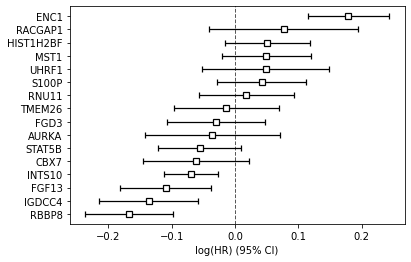

In [9]:
gene_list = [
    # "OS_YEARS",
    "OS_MONTHS",
    "OS_STATUS_INT",
    "RACGAP1",
    "STAT5B",
    "RBBP8",
    "ENC1",
    "RNU11",
    "UHRF1",
    "S100P",
    "MST1",
    "FGF13",
    "CBX7",
    "INTS10",
    "HIST1H2BF",
    "AURKA",
    "IGDCC4",
    "FGD3",
    "TMEM26",
]


cph = CoxPHFitter()
cph.fit(
    df_merged[gene_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

Iteration 1: norm_delta = 0.37958, step_size = 0.9000, log_lik = -6804.90663, newton_decrement = 98.65800, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.03099, step_size = 0.9000, log_lik = -6708.95167, newton_decrement = 0.71944, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00321, step_size = 0.9000, log_lik = -6708.23808, newton_decrement = 0.00773, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -6708.23036, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1743 total observations, 737 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1743
number of events observed = 1006
   partial log-likelihood = -6708.23
         time fit was run = 2022-09-04 13:08:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RNU11       0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
NLRX1      -0.03       0.97       0.03            -0.09             0.03                 0.92                 1.03
MTG2        0.12       1.13       0.03             0.07             0.17                 1.07                 1.19
FGF13      -0.09       0.92       0.04            -0.16            -0.02                 0.86                 0.98
PKMYT1      0.12       1.12       0.05             0.03             0.21                 1.03                 1.23
GABRB1      0.06       1.06       0.03             0.00             0.12                 1.00                 1.13
S100P       0.09       1.10       0.03             0.02             0.16                 1.02                 1.17
RNASE9      0.11       1.11       0.03             0.04             0.17                 1.05                 1.19
STAT5B     -0.08       0.92       0.03            -0.14            -0.02                 0.87                 0.98
ENC1        0.19       1.21       0.03             0.13             0.25                 1.14                 1.29
AURKA       0.01       1.01       0.04            -0.07             0.09                 0.93                 1.09
USP30       0.10       1.10       0.03             0.04             0.16                 1.04                 1.17
RAB3B       0.05       1.05       0.03            -0.01             0.10                 0.99                 1.11
INTS10     -0.05       0.95       0.02            -0.10            -0.01                 0.91                 0.99

            cmp to     z      p   -log2(p)
covariate                                 
RNU11         0.00  0.87   0.38       1.39
NLRX1         0.00 -0.87   0.39       1.37
MTG2          0.00  4.35 <0.005      16.14
FGF13         0.00 -2.41   0.02       5.97
PKMYT1        0.00  2.53   0.01       6.46
GABRB1        0.00  2.03   0.04       4.55
S100P         0.00  2.69   0.01       7.11
RNASE9        0.00  3.35 <0.005      10.29
STAT5B        0.00 -2.68   0.01       7.08
ENC1          0.00  6.19 <0.005      30.59
AURKA         0.00  0.21   0.84       0.26
USP30         0.00  3.18 <0.005       9.41
RAB3B         0.00  1.58   0.12       3.12
INTS10        0.00 -2.24   0.02       5.34
---
Concordance = 0.65
Partial AIC = 13444.46
log-likelihood ratio test = 193.35 on 14 df
-log2(p) of ll-ratio test = 109.30

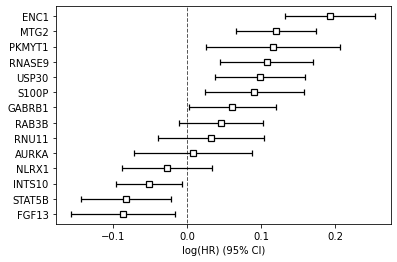

In [10]:
gene_list = [
    "OS_MONTHS",
    "OS_STATUS_INT",
    "RNU11",
    "NLRX1",
    "MTG2",
    "FGF13",
    "PKMYT1",
    "GABRB1",
    "S100P",
    "RNASE9",
    "STAT5B",
    "ENC1",
    "AURKA",
    "USP30",
    "RAB3B",
    "INTS10",
]


cph = CoxPHFitter()
cph.fit(
    df_merged[gene_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

## genes gelonging to only mrna_agilent_microarray_zscores_ref_diploid_samples

Iteration 1: norm_delta = 0.33312, step_size = 0.9000, log_lik = -6804.90663, newton_decrement = 76.57611, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.04542, step_size = 0.9000, log_lik = -6730.31049, newton_decrement = 0.98902, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00538, step_size = 0.9000, log_lik = -6729.32321, newton_decrement = 0.01321, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, log_lik = -6729.30998, newton_decrement = 0.00000, seconds_since_start = 0.3
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1743 total observations, 737 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1743
number of events observed = 1006
   partial log-likelihood = -6729.31
         time fit was run = 2022-09-04 13:08:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
CYP2D6     -0.05       0.96       0.03            -0.11             0.02                 0.90                 1.02
PTX4        0.05       1.05       0.03            -0.01             0.11                 0.99                 1.12
BIK         0.09       1.09       0.03             0.02             0.15                 1.02                 1.16
DENND6A    -0.05       0.95       0.03            -0.11             0.01                 0.89                 1.01
MIR137HG    0.04       1.05       0.03            -0.02             0.11                 0.98                 1.11
NMRK1      -0.11       0.89       0.03            -0.17            -0.05                 0.84                 0.95
SPATA4     -0.15       0.86       0.04            -0.22            -0.08                 0.80                 0.92
TBC1D31     0.11       1.11       0.02             0.06             0.15                 1.06                 1.17
MTG2        0.08       1.08       0.03             0.03             0.13                 1.03                 1.14
PJVK       -0.09       0.92       0.03            -0.15            -0.02                 0.86                 0.98
FCN2        0.07       1.07       0.03             0.00             0.13                 1.00                 1.14
RNASE9      0.08       1.09       0.03             0.02             0.15                 1.02                 1.16
SULT4A1    -0.08       0.92       0.04            -0.15            -0.01                 0.86                 0.99

            cmp to     z      p   -log2(p)
covariate                                 
CYP2D6        0.00 -1.39   0.17       2.60
PTX4          0.00  1.52   0.13       2.96
BIK           0.00  2.52   0.01       6.42
DENND6A       0.00 -1.68   0.09       3.43
MIR137HG      0.00  1.42   0.15       2.69
NMRK1         0.00 -3.78 <0.005      12.64
SPATA4        0.00 -4.07 <0.005      14.37
TBC1D31       0.00  4.44 <0.005      16.78
MTG2          0.00  3.02 <0.005       8.63
PJVK          0.00 -2.62   0.01       6.83
FCN2          0.00  1.99   0.05       4.41
RNASE9        0.00  2.63   0.01       6.87
SULT4A1       0.00 -2.27   0.02       5.42
---
Concordance = 0.63
Partial AIC = 13484.62
log-likelihood ratio test = 151.19 on 13 df
-log2(p) of ll-ratio test = 82.80

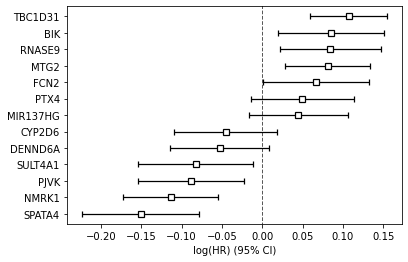

In [11]:
gene_list = [
    # "OS_YEARS",
    "OS_MONTHS",
    "OS_STATUS_INT",
    "CYP2D6",
    "PTX4",
    "BIK",
    "DENND6A",
    "MIR137HG",
    "NMRK1",
    "SPATA4",
    "TBC1D31",
    "MTG2",
    "PJVK",
    "FCN2",
    "RNASE9",
    "SULT4A1",
]

cph = CoxPHFitter()
cph.fit(
    df_merged[gene_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig("cph.png")

## genes belonging to mrna_agilent_microarray_zscores_ref_diploid_samples

Iteration 1: norm_delta = 0.29232, step_size = 0.9000, log_lik = -6804.90663, newton_decrement = 56.24640, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.02051, step_size = 0.9000, log_lik = -6750.52153, newton_decrement = 0.25193, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00212, step_size = 0.9000, log_lik = -6750.27189, newton_decrement = 0.00261, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -6750.26928, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1743 total observations, 737 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1743
number of events observed = 1006
   partial log-likelihood = -6750.27
         time fit was run = 2022-09-04 13:08:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PPIL3      -0.17       0.84       0.03            -0.23            -0.11                 0.80                 0.90
MST1       -0.02       0.98       0.03            -0.08             0.05                 0.92                 1.05
CBX7       -0.14       0.87       0.04            -0.21            -0.07                 0.81                 0.94
INTS10     -0.09       0.91       0.02            -0.13            -0.05                 0.88                 0.95
SPATA18    -0.07       0.93       0.03            -0.14            -0.00                 0.87                 1.00
FGD3       -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01

            cmp to     z      p   -log2(p)
covariate                                 
PPIL3         0.00 -5.60 <0.005      25.46
MST1          0.00 -0.51   0.61       0.71
CBX7          0.00 -3.76 <0.005      12.53
INTS10        0.00 -4.33 <0.005      16.03
SPATA18       0.00 -2.02   0.04       4.51
FGD3          0.00 -1.70   0.09       3.50
---
Concordance = 0.62
Partial AIC = 13512.54
log-likelihood ratio test = 109.27 on 6 df
-log2(p) of ll-ratio test = 68.23

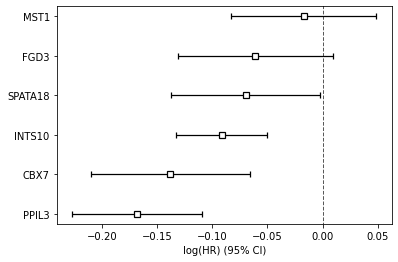

In [12]:
gene_list = [
    # "OS_YEARS",
    "OS_MONTHS",
    "OS_STATUS_INT",
    "PPIL3",
    "MST1",
    "CBX7",
    "INTS10",
    "SPATA18",
    "FGD3",
]

cph = CoxPHFitter()
cph.fit(
    df_merged[gene_list],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig("cph.png")

In [13]:
df_merged.columns

Index(['PATIENT_ID', 'OS_05years', 'OS_10years', 'OS_15years',
       'CLAUDIN_SUBTYPE', 'RNF165', 'PHF7', 'CIDEA', 'TENT2', 'SLC17A3',
       ...
       'HORMONE_THERAPY', 'RADIO_THERAPY', 'BREAST_SURGERY', 'OS_MONTHS',
       'OS_STATUS', 'VITAL_STATUS', 'RFS_STATUS', 'RFS_MONTHS',
       'OS_STATUS_INT', 'target_gene'],
      dtype='object', length=17578)